<a href="https://colab.research.google.com/github/tamer017/Cairo-Temperature-forecasting/blob/main/time_series_forecasting_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**I-*Import* Dependencies** 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# II-Read The Data

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
df = pd.read_csv('/content/drive/MyDrive/city_temperature.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### **II-1 Drop null columns**

In [51]:
df.isnull().sum()

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

In [52]:
# drop the state column since it has more the one million null raws
df.drop(["State"],axis=1,inplace=True)

### **II-2 Drop the Region and Country columns and take cairo only from City column**

In [53]:
df.drop(["Region","Country"],axis=1,inplace=True)
df=df[df.City=="Cairo"]

### **I-3 convert the temperature from Fahrenheit to Celsius**

In [54]:
df["AvgTemperature"]=(df["AvgTemperature"]-32)*(5/9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### **II-4 Remove Outliers**

In [55]:
describtion = df.AvgTemperature.describe()
Q1 = describtion["25%"]
Q3 = describtion["75%"]
IQR = Q3-Q1
UPPER_OUTLIER = Q3 + 1.5*IQR
LOWER_OUTLIER = Q1 - 1.5*IQR
UPPER_OUTLIER,LOWER_OUTLIER

(43.75, 1.3055555555555554)

#### **II-4 Remove outliers**

In [56]:
print(df.shape)
df=df[(df.AvgTemperature > LOWER_OUTLIER) & (df.AvgTemperature < UPPER_OUTLIER)]
print(df.shape)


(9266, 5)
(9227, 5)


### **II-5 Create DateTime**

In [40]:
def create_DateTime(x):
  out="0"+str(x["Day"]) if x["Day"]//10==0 else str(x["Day"])
  out+="-"
  out+="0"+str(x["Month"]) if x["Month"]//10==0 else str(x["Month"])
  out+="-"
  out+=str(x["Year"])
  return out

In [41]:
df['DateTime']=df.apply(lambda x:create_DateTime(x),axis=1)

### **II-6 sort the data by DateTime**

In [42]:
df = df.sort_values(by="DateTime")
df.DateTime=pd.to_datetime(df.DateTime)

### **II-7 Plot dates vs temperature**

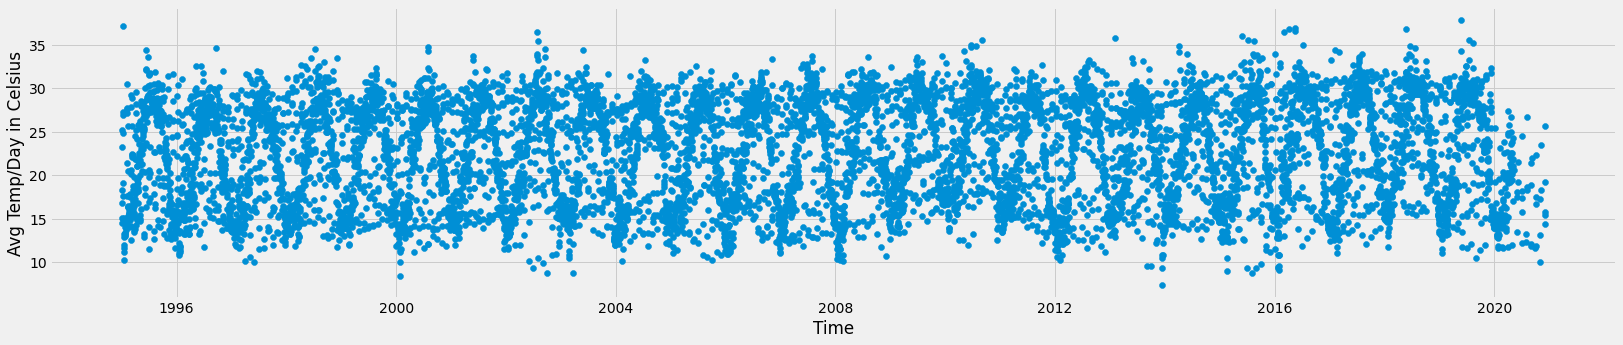

In [43]:
plt.figure(figsize=(25, 5))
plt.scatter(df.DateTime,df.AvgTemperature)
plt.xlabel("Time")
plt.ylabel("Avg Temp/Day in Celsius")
plt.show()

# **III - Create features**

In [44]:
def create_features(df):
    """
    Create time series features based on DateTime column and drop all the old features.
    """
    df['dayofweek'] = df.DateTime.dt.dayofweek
    df['quarter'] = df.DateTime.dt.quarter
    df['month'] = df.DateTime.dt.month
    df['year'] = df.DateTime.dt.year
    df['dayofyear'] = df.DateTime.dt.dayofyear
    df['dayofmonth'] = df.DateTime.dt.day
    df['weekofyear'] = df.DateTime.dt.isocalendar().week.astype(np.int32)
    df.drop(["City","Month","Day","Year"],axis=1,inplace=True)
    return df
df=create_features(df)

# **IV-Train / Test Split**

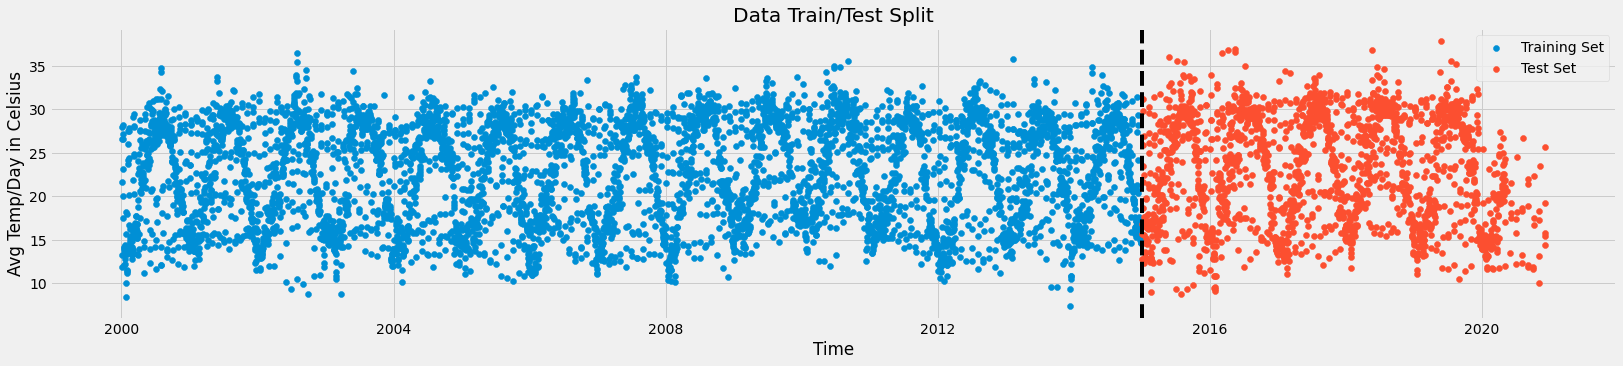

In [45]:
train = df.loc[(df.DateTime < '01-01-2015') & (df.DateTime > '01-01-2000')]
test = df.loc[df.DateTime >= '01-01-2015']
trainInput=train.iloc[:,2:]
trainOutput=train["AvgTemperature"]
testInput=test.iloc[:,2:]
testOutput=test["AvgTemperature"]
plt.figure(figsize=(25, 5))
plt.scatter(train.DateTime,train.AvgTemperature)
plt.title('Data Train/Test Split')
plt.scatter(test.DateTime,test.AvgTemperature)
plt.legend(['Training Set', 'Test Set'])
plt.axvline(pd.to_datetime('01-01-2015'), color='black', ls='--')
plt.xlabel("Time")
plt.ylabel("Avg Temp/Day in Celsius")
plt.show()

## **V-Visualize our Feature / Target Relationship**

### **V-1 Plot the days of year temperature**

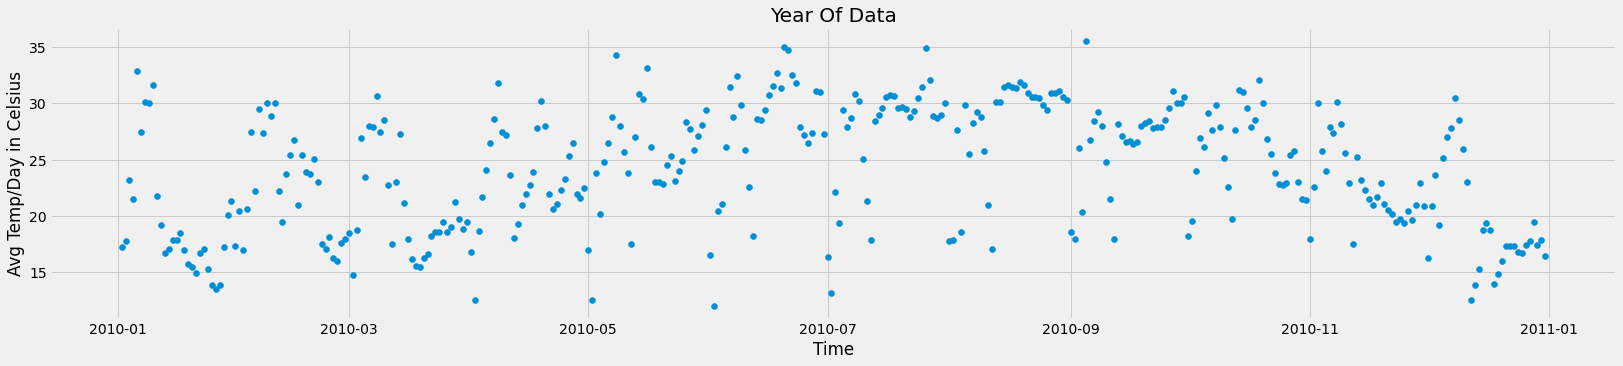

In [46]:
year_df=df.loc[(df.DateTime > '01-01-2010') & (df.DateTime < '01-01-2011')]
plt.figure(figsize=(25, 5))
plt.scatter(year_df.DateTime,year_df.AvgTemperature )
plt.title('Year Of Data')
plt.xlabel("Time")
plt.ylabel("Avg Temp/Day in Celsius")
plt.show()

**V-2 Plot the month of year temperature**

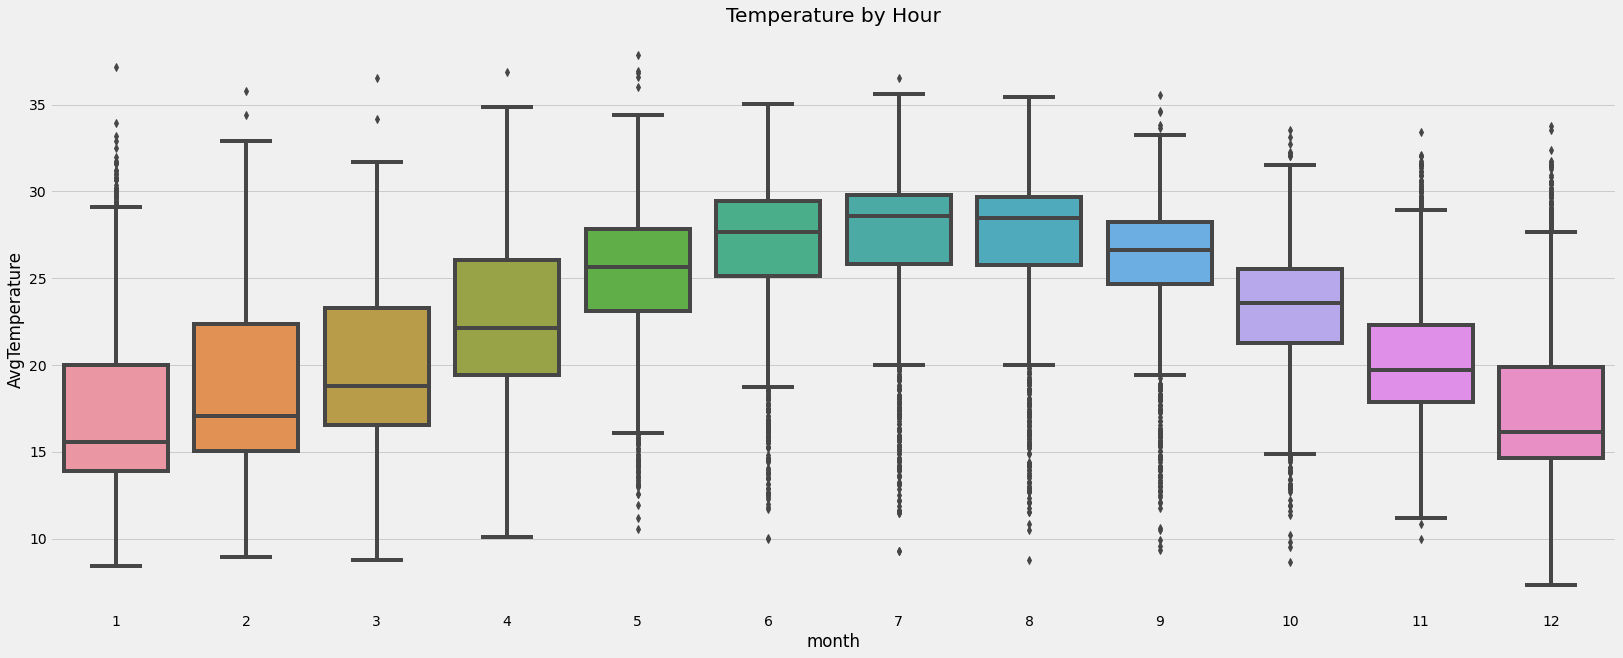

In [47]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.boxplot(data=df, x='month', y='AvgTemperature')
ax.set_title('Temperature by Hour')
plt.show()

## **VI - Create our Model**

In [ ]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.01,0.03, 0.05, 0.07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [15],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000,1500,2000]}
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=100)
xgb_grid.fit(trainInput,
         trainOutput,eval_set=[(trainInput, trainOutput), (testInput, testOutput)])

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[0]	validation_0-rmse:22.6676	validation_1-rmse:23.157
[1]	validation_0-rmse:22.45	validation_1-rmse:22.9409
[2]	validation_0-rmse:22.2304	validation_1-rmse:22.7238
[3]	validation_0-rmse:22.0175	validation_1-rmse:22.5124
[4]	validation_0-rmse:21.8051	validation_1-rmse:22.3018
[5]	validation_0-rmse:21.5944	validation_1-rmse:22.0928
[6]	validation_0-rmse:21.3856	validation_1-rmse:21.8857
[7]	validation_0-rmse:21.179	validation_1-rmse:21.6809
[8]	validation_0-rmse:20.9723	validation_1-rmse:21.4766
[9]	validation_0-rmse:20.7677	validation_1-rmse:21.2743
[10]	validation_0-rmse:20.567	validation_1-rmse:21.0753
[11]	validation_0-rmse:20.369	validation_1-rmse:20.8788
[12]	validation_0-rmse:20.1759	validation_1-rmse:20.687
[13]	validation_0-rmse:19.9787	validation_1-rmse:20.4922
[14]	validation_0-rmse:19.7886	validation_1-rmse:20.3035
[15]	validation_0-rmse:19.5981	validation_1-rmse:20.1148
[16]	validation_0-rmse:19.4066	validation_1-

GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [15],
                         'n_estimators': [500, 1000, 1500, 2000],
                         'nthread': [4], 'objective': ['reg:linear'],
                         'silent': [1], 'subsample': [0.7]},
             verbose=100)

# Feature Importance

In [ ]:
xgb_grid.best_estimator_

XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=6,
             min_child_weight=15, n_estimators=500, nthread=4, silent=1,
             subsample=0.7)

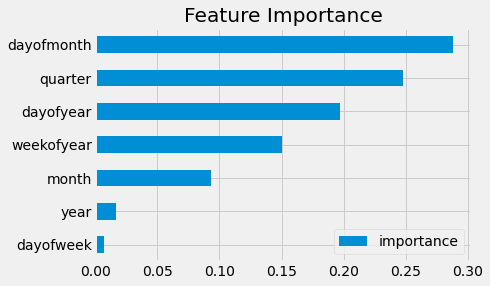

In [ ]:
fi = pd.DataFrame(data=xgb_grid.best_estimator_.feature_importances_,
             index=trainInput.columns,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


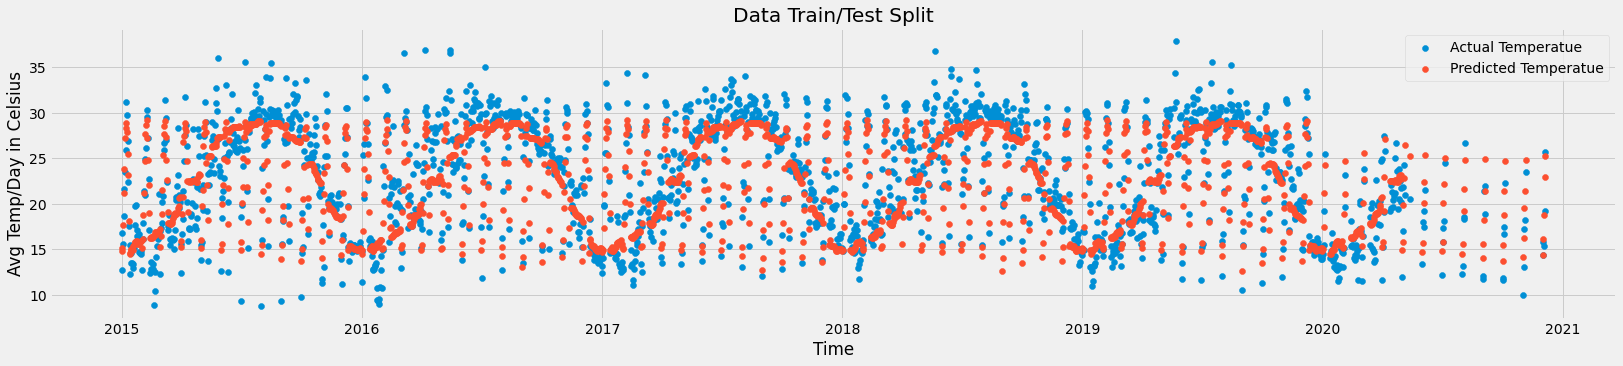

In [ ]:
test['Prediction'] = xgb_grid.predict(testInput)
plt.figure(figsize=(25, 5))
plt.scatter(test.DateTime,test.AvgTemperature)
plt.title('Data Train/Test Split')
plt.scatter(test.DateTime,test.Prediction)
plt.legend(['Actual Temperatue', 'Predicted Temperatue'])
plt.xlabel("Time")
plt.ylabel("Avg Temp/Day in Celsius")
plt.show()

# Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test.AvgTemperature, test['Prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2.63


# Calculate Error
- Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test.AvgTemperature - test['Prediction'])
test.groupby(['DateTime'])['error'].mean().sort_values(ascending=False).head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


DateTime
2016-02-18    11.918295
2016-05-14    11.769336
2016-05-15    11.488089
2019-05-23    11.459909
2016-09-04    11.080933
2018-05-22    10.505369
2016-03-06     9.862519
2016-04-06     9.369281
2018-10-05     9.353854
2015-03-27     9.206611
Name: error, dtype: float64

The worest error is 11.9 celsius degree

# The End